In [1]:
 # フォントを全て読み込み
import matplotlib.pyplot as plt
import japanize_matplotlib

fonts = set([f.name for f in 
             matplotlib.font_manager.fontManager.ttflist])
plt.rcParams['font.family'] = "MS Gothic"

In [2]:
import statsmodels.api as sm
import pandas_datareader.data as web
import numpy as np
import pandas as pd

In [3]:
end='2022/12/31'
lnn225 = np.log(web.DataReader(
    "NIKKEI225", 'fred',"1949/5/16",end)).dropna()

In [4]:
a=sm.tsa.adfuller(lnn225.NIKKEI225,regression='n')
b,c,d,e,f,g=a
print(f"結果は、adf検定統計値が{b:2.2f},そのp値が{c:2.2f}となる。また、")
print(f"ラグ数    {d}")
print(f"データ数  {e}")
print(f"臨界値 1%:{f['1%']:2.2f};5%:{f['5%']:2.2f};10%:{f['10%']:2.2f}である。")

結果は、adf検定統計値が2.42,そのp値が1.00となる。また、
ラグ数    26
データ数  18268
臨界値 1%:-2.57;5%:-1.94;10%:-1.62である。


In [5]:
states=['全期間','戦後復興期','高度経済成長期','安定成長期','バブル期',
        'バブルピークまで','バブル暴落','調整期','アベノミクス']
starts=["1949/5/16","1949/5/16","1954/12/1",'1972/1/1',"1986/12/1",
        "1986/12/1","1990/1/1","1993/11/1", "2012/11/1"]
ends=[end,"1954/11/30",'1972/12/31',"1986/11/30","1993/10/31",
      "1989/12/31","1992/8/31","2012/10/31",end]

In [6]:
def adftest(tsd,adftype):
    results=[]
    for i,(start,end) in enumerate(zip(starts,ends)):
        tsd0=tsd.loc[start:end].copy()
        results.append(sm.tsa.adfuller(tsd0,regression=adftype)[1])
    return results

pd.options.display.precision = 2
pd.set_option('display.float_format', lambda x: '%.2f' % x)

adftype=['n','c','ct']
summaries=[]
for adf in adftype:
    summaries.append(adftest(lnn225,adf))
print("表7.1: 各経済循環期におけるN225の単位根検定のp値")
pd.DataFrame(np.array(summaries).T,index=states,columns=adftype)

表7.1: 各経済循環期におけるN225の単位根検定のp値


,n,c,ct
全期間,1.00,0.11,0.75
戦後復興期,0.90,0.90,0.50
高度経済成長期,1.00,0.96,0.94
安定成長期,1.00,0.96,0.84
バブル期,0.71,0.61,0.41
バブルピークまで,1.00,0.77,0.31
バブル暴落,0.07,0.44,0.32
調整期,0.41,0.60,0.40
アベノミクス,0.97,0.03,0.00


In [7]:
summaries=[]
for adf in adftype:
    summaries.append(adftest(lnn225.resample('ME').last(),adf))
print("表7.2: 各経済循環期におけるN225(月次)の単位根検定のp値")
pd.DataFrame(np.array(summaries).T,index=states,columns=adftype)

表7.2: 各経済循環期におけるN225(月次)の単位根検定のp値


,n,c,ct
全期間,0.99,0.03,0.44
戦後復興期,0.87,0.90,0.37
高度経済成長期,1.00,0.97,0.94
安定成長期,1.00,1.00,0.96
バブル期,0.70,0.55,0.36
バブルピークまで,1.00,0.99,0.00
バブル暴落,0.15,0.38,0.15
調整期,0.40,0.53,0.37
アベノミクス,0.98,0.03,0.00


In [8]:
def interval_adf(tsd,interval,adf):
    results=[]
    for nnn in interval:
        no=int(len(tsd)/nnn)
        nrw=0    
        for i in range(no):
            if i<no-1:
                tsd0=tsd.iloc[i*nnn:(1+i)*nnn].copy()
            else:
                tsd0=tsd.iloc[i*nnn:-1].copy()
            y=tsd0.dropna()
            if sm.tsa.adfuller(y,regression=adf)[1]<0.1:
                nrw+=1
        results.append([nrw/no])
    return pd.DataFrame(results,index=interval,columns=[adf])

In [9]:
interval=np.arange(20,60,10)
results=interval_adf(lnn225.copy(),interval,adftype[0])
for adf in adftype[1:]:
        results[adf]=interval_adf(lnn225.copy(),interval,adf).values
results

,n,c,ct
20,0.00,0.30,0.25
30,0.08,0.17,0.24
40,0.05,0.13,0.19
50,0.04,0.12,0.18


In [10]:
interval=np.arange(12,100,12)
results=interval_adf((lnn225.copy()).resample('ME').last(),interval,adftype[0])
for adf in adftype[1:]:
        results[adf]=interval_adf(lnn225.copy(),interval,adf).values
results

,n,c,ct
12,0.00,0.26,0.29
24,0.06,0.20,0.25
36,0.04,0.13,0.22
48,0.00,0.12,0.16
60,0.00,0.14,0.15
72,0.08,0.09,0.15
84,0.00,0.12,0.12
96,0.00,0.10,0.13


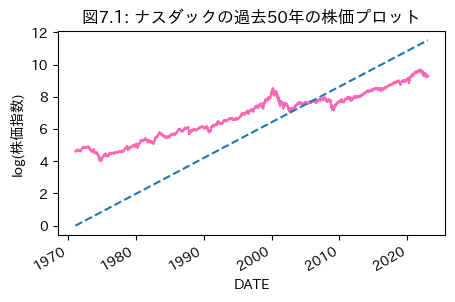

In [11]:
lnNDQCOM = np.log(web.DataReader("NASDAQCOM", 'fred',"1949/5/16",end))\
                                                                .dropna()
lnNDQCOM.columns=['Close']
lnNDQCOM.Close.plot(color='hotpink',figsize=(5,3))
lnNDQCOM["t"]=range(len(lnNDQCOM))
model=sm.OLS(lnNDQCOM.Close,lnNDQCOM.t)
results=model.fit()
results.fittedvalues.plot(label='prediction',style='--')
plt.ylabel('log(株価指数)')
plt.title('図7.1: ナスダックの過去50年の株価プロット')
plt.show()

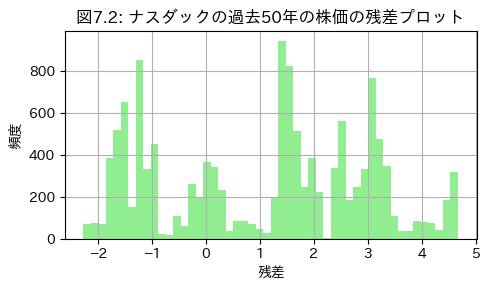

In [12]:
results.resid.hist(bins=50,color='lightgreen',figsize=(5,3))
plt.ylabel('頻度')
plt.xlabel('残差')
plt.title('図7.2: ナスダックの過去50年の株価の残差プロット')
plt.tight_layout()
#plt.savefig('0702.jpeg',dpi=600)
plt.show()

In [13]:
interval=np.arange(20,60,10)
tsd=lnNDQCOM.Close.copy()
results=interval_adf(tsd,interval,adftype[0])
for adf in adftype[1:]:
        results[adf]=interval_adf(tsd,interval,adf).values
results

,n,c,ct
20,0.00,0.28,0.23
30,0.07,0.16,0.23
40,0.05,0.13,0.20
50,0.02,0.11,0.20


In [14]:
interval=np.arange(12,100,24)
tsd=(lnNDQCOM.Close.copy()).resample('ME').last()
results=interval_adf(tsd,interval,adftype[0])
for adf in adftype[1:]:
        results[adf]=interval_adf(tsd,interval,adf).values
results

,n,c,ct
12,0.00,0.31,0.22
36,0.00,0.24,0.29
60,0.00,0.10,0.20
84,0.00,0.00,0.29
